In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer 
#pd.set_option('display.max_rows', None) 

In [2]:
df=pd.read_csv('./food.csv',sep='\t',low_memory=False)

In [3]:
df.shape ## 320772 lignes et 172 colonnes

(320772, 162)

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Traitements des colonnes

In [5]:
## fonction renvoyant les colonnes et le pourcentage de valeurs nulles pour chacune d'elle
def columns_na_percentage(df):
    na_df=(df.isnull().sum()/len(df)*100).sort_values(ascending=False).reset_index()
    na_df.columns = ['Column','na_rate_percent']
    return na_df
  

In [6]:
## variables comportant plus de 50% de valeurs manquantes
na_df=columns_na_percentage(df)
na_columns=na_df[na_df['na_rate_percent']>=50] ## 128 colonnes ont plus de 50% de valeurs nulles
#na_columns[na_columns['Column']=='manufacturing_places']
na_columns

,Column,na_rate_percent
0,water-hardness_100g,100.000000
1,nervonic-acid_100g,100.000000
2,no_nutriments,100.000000
3,ingredients_from_palm_oil,100.000000
4,ingredients_that_may_be_from_palm_oil,100.000000
...,...,...
123,calcium_100g,56.027958
124,trans-fat_100g,55.327148
125,cholesterol_100g,55.080244
126,additives_tags,51.778834


In [7]:
## suppression des colonnes ayant plus 50% de valeurs nulles
df.drop(columns=na_columns['Column'].tolist(),axis=1,inplace=True)

## Traitement des lignes

In [8]:
## le nom du produit censé être unique et non nul
## suppression de toutes les lignes dont le nom du produit est non renseigné ou nul
mask_to_remove=df[(pd.isna(df['product_name']))|(df['product_name'].str.strip()=='')]
len(mask_to_remove['product_name'] )##17765 lignes à supprimmer
#df=df[~pd.isna(df['product_name'])]

17765

In [9]:
## suppression des produits dont les noms ne sont pas renseignés
df.drop(mask_to_remove.index,inplace=True)

In [10]:
## vérification de doublons pour le nom du produit 106092 doublons
df[df['product_name'].duplicated(keep=False)][['product_name','last_modified_t']]

,product_name,last_modified_t
0,Farine de blé noir,1474103893
2,Peanuts,1489069957
4,Organic Polenta,1489055653
6,Organic Long Grain White Rice,1489055730
7,Organic Muesli,1489055712
...,...,...
320753,Lager,1444561971
320754,nf test,1472253428
320757,Amandes,1491079939
320760,Poireaux,1460898286


In [11]:
## suppression des doublons sur les produits
df.drop_duplicates(subset='product_name',keep='last',inplace=True)

In [12]:
## identification des colonnes décrivant la part nutritionnelle pour 100g
nutriment_cols=[i for i in df.columns.tolist() if i.endswith('_100g')]
nutriment_cols

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [13]:
## vérification des lignes comportant des valeurs nutritionnelles négatives
negative_cols=[]
for col in nutriment_cols:
    if len(df[df[col]<0])>0:
        negative_cols.append(col)

print('columns with negative values',negative_cols) 
## les variables ['sugars_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-fr_100g']
              ## comportent des valeurs négatives
## suppression des lignes comportant des valeurs nutritionnelles négatives
for col in negative_cols:
    df.drop(index=df.loc[df[col]<0,col].index,inplace=True)



columns with negative values ['sugars_100g', 'fiber_100g', 'proteins_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


In [14]:
## identification des lignes dont toutes les valeurs nutritionnelles sont inconnues
all_missing_nutritional = df[df["energy_100g"].isna()
                            & df["proteins_100g"].isna()
                            & df["sugars_100g"].isna()
                            & df["fat_100g"].isna()
            &df['sugars_100g'].isna()&
 df['fiber_100g'].isna() & df[ 'nutrition-score-fr_100g'].isna()& df['nutrition-score-uk_100g'].isna() 
                            & df["saturated-fat_100g"].isna()
                            & df["carbohydrates_100g"].isna()
                            & df["sodium_100g"].isna() 
                    ] 
len(all_missing_nutritional[nutriment_cols] )## 35727

35727

In [15]:
## suppression des lignes dont toutes les valeurs nutritives sont inconnues ainsi que les nutriscores
df.drop(all_missing_nutritional.index,inplace=True)



# Sélection des variables

In [16]:
df.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'brands',
 'brands_tags',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'serving_size',
 'additives_n',
 'additives',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'states',
 'states_tags',
 'states_fr',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g']

In [17]:
## les colonnes code, url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime
  # sont peu utiles, et plus relatives au stockage en base de données

## les variables 'nutrition-score-uk_100g' et 'nutrition-score-fr_100g' sont identiques
## les variables countries et states, sont des concaténation de pays ce qui peut s'avérer très complexe


## Au final, on ne garde que les colonnes des valeurs nutritives des produits et
## leur nutriscore et nutri_grade ainsi que leur marques (brands),le nombre d'additif (additives_n) ,
## le nombre d'ingrédients issus de l'huile de palme (ingredients_from_palm_oil_n) 
## dont la participe à la déforestation

relevant_cols=nutriment_cols

relevant_cols.remove('nutrition-score-uk_100g')
relevant_cols.append('nutrition_grade_fr')
relevant_cols.append('additives_n')
relevant_cols.append('brands')
relevant_cols.append('ingredients_from_palm_oil_n')
relevant_cols.append('product_name')


In [18]:
relevant_cols

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g',
 'nutrition_grade_fr',
 'additives_n',
 'brands',
 'ingredients_from_palm_oil_n',
 'product_name']

In [19]:
df=df[relevant_cols]

# Analyse et recherche des valeurs aberrantes avec IQR (Inter Quartile Range)

In [20]:
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n
count,158732.000000,146405.000000,137331.000000,146117.000000,147972.000000,117993.000000,157835.000000,154379.000000,154348.00000,132012.000000,141528.000000,141528.000000
mean,1206.944242,14.048120,6.084423,33.834509,18.470844,2.606604,7.007809,2.398653,0.94454,11.722139,2.213152,0.026292
std,1110.392305,17.140343,8.446454,30.295514,23.873615,16.228155,8.255015,164.810787,64.89265,7.812134,2.654547,0.161977
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,494.000000,0.100000,0.100000,6.600000,1.700000,0.000000,0.500000,0.100000,0.03937,4.000000,0.000000,0.000000
50%,1207.000000,8.330000,3.200000,25.100000,8.330000,1.200000,4.760000,0.706120,0.27800,12.000000,1.000000,0.000000
75%,1782.000000,22.500000,8.930000,60.000000,30.000000,3.500000,9.890000,1.524000,0.60000,18.000000,3.000000,0.000000
max,231199.000000,380.000000,550.000000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.00000,40.000000,31.000000,2.000000


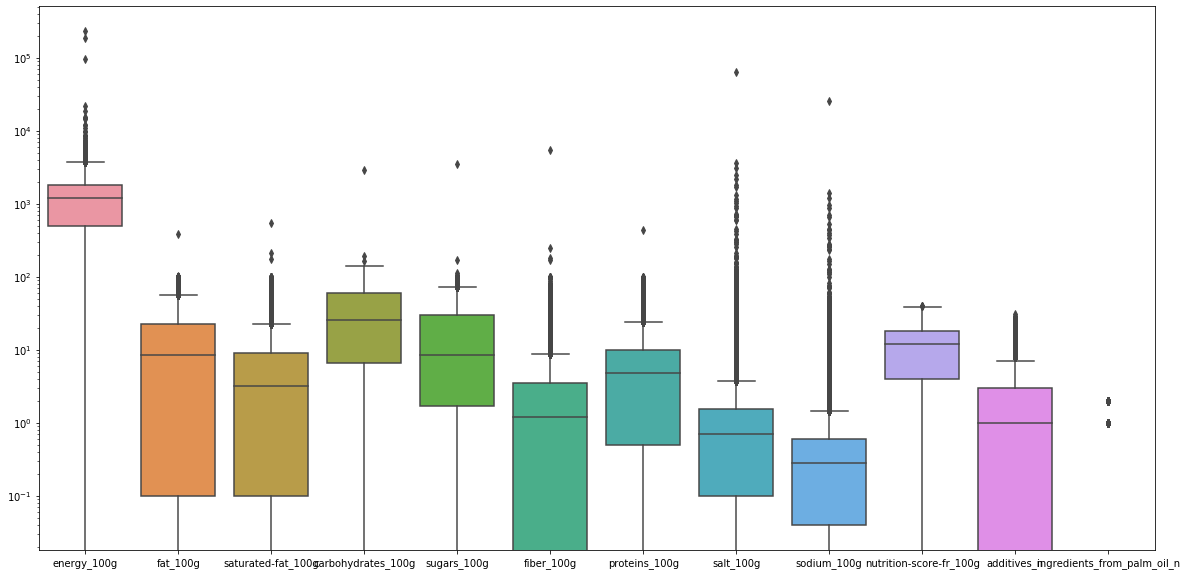

In [21]:
## afin de détecter d'éventuelles valeurs aberrantes, 
## nous traçons les boxplot pour  chaque valeurs nutritives ainsi que les nutriscore

## boxplot
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10
g=sns.boxplot(data=df[nutriment_cols])
g.set_yscale("log")

## présence de plusieurs valeurs aberrantes sauf pour le nutriscore


In [22]:
## suppression de toutes les valeurs nutririonnelles supérieures à 100g
##df[df[nutriment_cols]>100]
nutriment_cols=[i for i in df.columns.tolist() if i.endswith('_100g')]
for col in nutriment_cols:
    if col !='energy_100g':
        if len(df[df[col]>100]):
            #print(df[df[col]>100][col])
            df.drop(index=df[df[col]>100].index,inplace=True)

In [23]:
## fonction qui calcule les valeurs aberrantes et les supprime et renvoit un nouveau dataframe
from scipy import stats
import numpy as np
 

def find_outliers_and_clean(cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    outliers= df[((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    #print(outliers.head(5))
    new_df=df.drop(index=outliers.index)
    return new_df
    

In [24]:
## suppression des valeurs aberrantes de la variables energy
df=find_outliers_and_clean(nutriment_cols)
df.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n
count,125765.000000,115985.000000,109009.000000,115806.000000,118768.000000,94312.000000,125063.00000,121935.000000,121906.000000,106136.000000,111865.00000,111865.000000
mean,1073.398218,11.286416,4.894795,33.178247,17.131319,1.796966,5.82975,0.830342,0.326983,10.902785,2.40126,0.029241
std,720.779712,12.067669,5.677417,28.054356,19.027969,2.117400,5.82705,0.830590,0.327004,7.898004,2.73934,0.170800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,408.000000,0.100000,0.100000,7.080000,2.000000,0.000000,0.78000,0.100000,0.039370,3.000000,0.00000,0.000000
50%,1046.000000,7.140000,2.700000,25.000000,8.800000,1.100000,4.35000,0.635000,0.250000,11.000000,2.00000,0.000000
75%,1674.000000,20.000000,7.600000,58.930000,28.570000,3.000000,8.33000,1.300480,0.512000,17.000000,3.00000,0.000000
max,3703.000000,56.000000,22.120000,100.000000,72.400000,8.750000,24.00000,3.660000,1.440000,37.000000,31.00000,2.000000


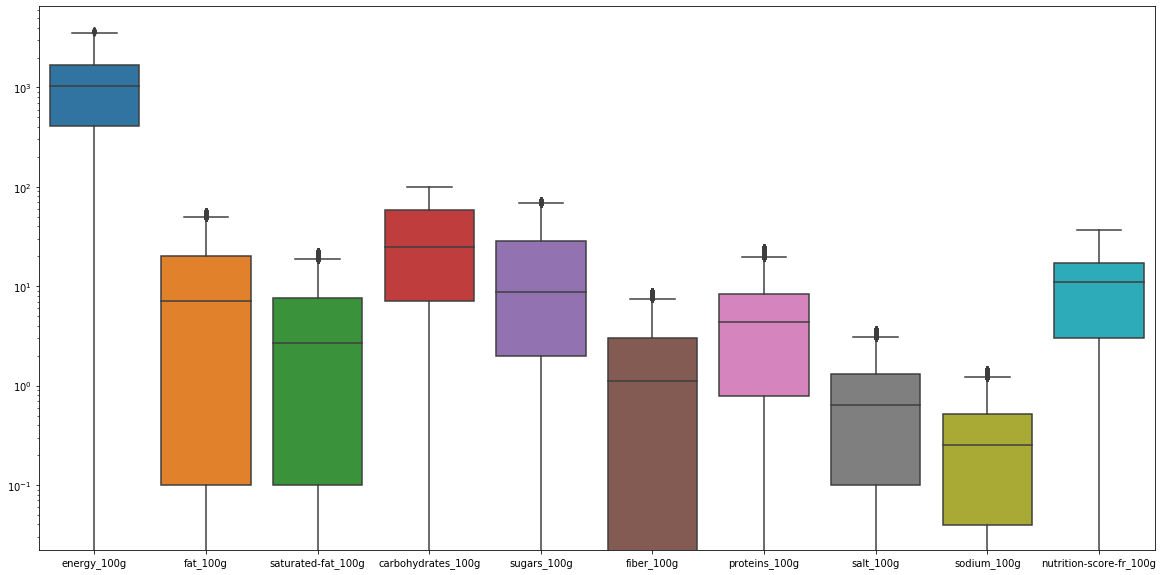

In [25]:
g=sns.boxplot(data=df[nutriment_cols])
g.set_yscale("log")

# Imputation des valeurs manquantes
  

In [26]:
## matrice de corrélation
numeric_columns=df.select_dtypes(exclude=['object']).columns.tolist()
numeric_columns.remove('sodium_100g') ## suppression de la colonne sodium avec une corrélation de 1 avec le sel
df[numeric_columns].corr()





,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n
energy_100g,1.000000,0.758530,0.581359,0.708755,0.467042,0.462163,0.338896,0.148094,0.725354,0.049713,0.139282
fat_100g,0.758530,1.000000,0.743103,0.139364,0.096631,0.305445,0.408966,0.222746,0.647768,-0.071890,0.102191
saturated-fat_100g,0.581359,0.743103,1.000000,0.111141,0.242458,0.106767,0.267208,0.019550,0.737629,-0.026854,0.122095
carbohydrates_100g,0.708755,0.139364,0.111141,1.000000,0.695825,0.409701,-0.060755,-0.078613,0.435403,0.147785,0.102577
sugars_100g,0.467042,0.096631,0.242458,0.695825,1.000000,0.163817,-0.232154,-0.346761,0.538808,0.107900,0.066393
fiber_100g,0.462163,0.305445,0.106767,0.409701,0.163817,1.000000,0.174417,0.037455,0.053182,-0.115603,0.077861
proteins_100g,0.338896,0.408966,0.267208,-0.060755,-0.232154,0.174417,1.000000,0.427451,0.150927,-0.064884,0.017615
salt_100g,0.148094,0.222746,0.019550,-0.078613,-0.346761,0.037455,0.427451,1.000000,0.208072,0.027306,-0.027164
nutrition-score-fr_100g,0.725354,0.647768,0.737629,0.435403,0.538808,0.053182,0.150927,0.208072,1.000000,0.106976,0.121096
additives_n,0.049713,-0.071890,-0.026854,0.147785,0.107900,-0.115603,-0.064884,0.027306,0.106976,1.000000,0.117780


In [27]:
## les colonnes ci-dessus sont fortement corrélées entre elles.
 # Utilisation Iterativeimputer pour imputer les valeurs manquantes
correlated_columns=['energy_100g','fat_100g','carbohydrates_100g',
                    'nutrition-score-fr_100g','saturated-fat_100g','sugars_100g']
un_correlated_columns=[x for x in numeric_columns if x not in correlated_columns]
un_correlated_columns

['fiber_100g',
 'proteins_100g',
 'salt_100g',
 'additives_n',
 'ingredients_from_palm_oil_n']

In [28]:
#imputation des valeurs nulles des variables corrélées entre elles par IterativeImputer

impute_it=IterativeImputer(missing_values=np.nan,min_value=0)
results=impute_it.fit_transform(df[correlated_columns])
df_imputed = pd.DataFrame(data = results,columns = correlated_columns)

/home/amadou/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [35]:
#imputation des valeurs nulles des variables non corrélées entre elles par KNNimputer

        
        
imputer = KNNImputer()
results = imputer.fit_transform(df[un_correlated_columns])
df_imputed_2=pd.DataFrame(data = results,columns = un_correlated_columns)

In [44]:
df[correlated_columns]=df_imputed.values
df[un_correlated_columns]=df_imputed_2.values



In [50]:
## suppression de la colonne sodium vu que c'est du sel
df.drop(columns=['sodium_100g'],inplace=True)
## remplacementt des valeurs inconnues nutrition_grade_fr par 'not_provided' autant pour la colonne brands

df["nutrition_grade_fr"].fillna("not_provided", inplace = True) 
df["brands"].fillna("not_provided", inplace = True) 

In [51]:
df.isnull().sum()/len(df)*100

energy_100g                    0.0
fat_100g                       0.0
saturated-fat_100g             0.0
carbohydrates_100g             0.0
sugars_100g                    0.0
fiber_100g                     0.0
proteins_100g                  0.0
salt_100g                      0.0
nutrition-score-fr_100g        0.0
nutrition_grade_fr             0.0
additives_n                    0.0
brands                         0.0
ingredients_from_palm_oil_n    0.0
product_name                   0.0
dtype: float64

In [52]:
df.to_csv('./cleaned_food.csv')